# Stonks 

Use tensorflow to build deep learning based time series forcasting models based on financial data.

Try out different neural network architectures, see which one works best for this task.

Keep track of the performance of all of the models.

Read the official Tensorflow time series forecasting [guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf

In [2]:
mpl.rcParams['figure.figsize'] = (16, 9)

### Dataset

Currently using `yfinance` to access yahoo finance historical data since it is free.

In [3]:
tickers = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'TQQQ', 'TSLA', 'BABA', 'FCEL', 'JETS']
tickers

['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'TQQQ', 'TSLA', 'BABA', 'FCEL', 'JETS']

In [4]:
def create_yfinance_df(tickers):
    return yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = '6mo',

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = '1d',

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )


In [5]:
multi_index_column_ticker_df = create_yfinance_df(tickers)

[*********************100%***********************]  10 of 10 completed


What do the first few entries look like? These should be the oldest.

In [6]:
multi_index_column_ticker_df.head()

FB                                                \
                  Open        High         Low       Close    Volume   
Date                                                                   
2020-06-30  220.589996  227.500000  218.470001  227.070007  33927100   
2020-07-01  228.500000  239.000000  227.559998  237.550003  43399700   
2020-07-02  239.000000  240.000000  232.610001  233.419998  30633600   
2020-07-06  233.759995  240.399994  232.270004  240.279999  26206200   
2020-07-07  239.410004  247.649994  238.820007  240.860001  27887800   

                  TQQQ                                                ...  \
                  Open        High         Low       Close    Volume  ...   
Date                                                                  ...   
2020-06-30   92.320000   98.480003   92.129997   97.650002  31423600  ...   
2020-07-01   97.860001  102.470001   97.239998  101.139999  31517200  ...   
2020-07-02  104.290001  105.870003  102.739998  103.290001  28519000  ...   
2020-07-06  107.300003  111.580002  107.290001  110.879997  26498000  ...   
2020-07-07  110.550003  114.160004  108.239998  108.699997  30762400  ...   

                  TSLA                                                 \
                  Open        High         Low       Close     Volume   
Date                                                                    
2020-06-30  201.300003  217.537994  200.746002  215.962006   84592500   
2020-07-01  216.600006  227.065994  216.100006  223.925995   66634500   
2020-07-02  244.296005  245.600006  237.119995  241.731995   86250500   
2020-07-06  255.337997  275.558014  253.207993  274.316010  102849500   
2020-07-07  281.002014  285.899994  267.342010  277.971985  107448500   

                   GOOG                                                  
                   Open         High          Low        Close   Volume  
Date                                                                     
2020-06-30  1390.439941  1418.650024  1383.959961  1413.609985  2042400  
2020-07-01  1411.099976  1443.000000  1409.819946  1438.040039  1775200  
2020-07-02  1446.939941  1482.949951  1446.420044  1464.699951  1859100  
2020-07-06  1480.060059  1506.589966  1472.859985  1495.699951  1564000  
2020-07-07  1490.000000  1516.800049  1483.550049  1485.180054  1458200  

[5 rows x 50 columns]

What do the last few entries look like? These should be the newest.

In [7]:
multi_index_column_ticker_df.tail()

FB                                                \
                  Open        High         Low       Close    Volume   
Date                                                                   
2020-12-22  271.500000  271.500000  264.630005  267.089996  17312900   
2020-12-23  266.890015  272.170013  266.230011  268.109985  14329000   
2020-12-24  268.880005  270.399994  266.200012  267.399994   6702000   
2020-12-28  268.739990  277.299988  265.660004  277.000000  23281100   
2020-12-29  276.950012  280.510010  276.290009  276.779999  16231243   

                  TQQQ                                                ...  \
                  Open        High         Low       Close    Volume  ...   
Date                                                                  ...   
2020-12-22  175.300003  176.710007  170.179993  175.050003  20041300  ...   
2020-12-23  175.039993  175.759995  172.179993  172.410004  14929300  ...   
2020-12-24  172.910004  175.440002  172.720001  174.649994   9633200  ...   
2020-12-28  179.160004  180.759995  176.029999  179.889999  14549400  ...   
2020-12-29  182.350006  183.399994  178.809998  180.419998  14924821  ...   

                  TSLA                                                \
                  Open        High         Low       Close    Volume   
Date                                                                   
2020-12-22  648.000000  649.880005  614.229980  640.340027  51716000   
2020-12-23  632.200012  651.500000  622.570007  645.979980  33173000   
2020-12-24  642.989990  666.090027  641.000000  661.770020  22865600   
2020-12-28  674.510010  681.400024  660.799988  663.690002  32133700   
2020-12-29  661.000000  669.900024  655.000000  665.989990  21863659   

                   GOOG                                                  
                   Open         High          Low        Close   Volume  
Date                                                                     
2020-12-22  1734.430054  1737.405029  1712.574951  1723.500000   936700  
2020-12-23  1728.109985  1747.989990  1725.040039  1732.380005  1033800  
2020-12-24  1735.000000  1746.000000  1729.109985  1738.849976   346800  
2020-12-28  1751.635010  1790.728027  1746.334961  1776.089966  1392500  
2020-12-29  1787.790039  1792.439941  1756.089966  1758.719971  1286642  

[5 rows x 50 columns]

In [8]:
multi_index_column_ticker_df.dtypes

FB    Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
TQQQ  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
NFLX  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
FCEL  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
JETS  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
AMZN  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
AAPL  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
BABA  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
TSLA  Open      float64
      High      

In [9]:
multi_index_column_ticker_df.describe().transpose()

count          mean           std           min           25%  \
FB   Open    127.0  2.655188e+02  1.707494e+01  2.205900e+02  2.568150e+02   
     High    127.0  2.694895e+02  1.716030e+01  2.275000e+02  2.594000e+02   
     Low     127.0  2.615825e+02  1.654294e+01  2.184700e+02  2.501200e+02   
     Close   127.0  2.656046e+02  1.687359e+01  2.270700e+02  2.548200e+02   
     Volume  127.0  2.184990e+07  9.985963e+06  6.702000e+06  1.625922e+07   
TQQQ Open    127.0  1.376011e+02  2.058112e+01  9.232000e+01  1.225550e+02   
     High    127.0  1.407936e+02  2.015782e+01  9.848000e+01  1.252900e+02   
     Low     127.0  1.335533e+02  2.043601e+01  9.213000e+01  1.166350e+02   
     Close   127.0  1.375219e+02  2.042700e+01  9.765000e+01  1.214900e+02   
     Volume  127.0  3.149967e+07  1.154794e+07  9.633200e+06  2.269390e+07   
NFLX Open    127.0  5.011311e+02  2.224400e+01  4.500200e+02  4.855900e+02   
     High    127.0  5.095192e+02  2.270959e+01  4.575900e+02  4.921400e+02   
     Low     127.0  4.925406e+02  2.007923e+01  4.470000e+02  4.788750e+02   
     Close   127.0  5.014874e+02  2.184217e+01  4.550400e+02  4.848350e+02   
     Volume  127.0  6.203618e+06  4.073889e+06  1.144000e+06  3.748300e+06   
FCEL Open    127.0  3.895906e+00  2.727846e+00  1.950000e+00  2.365000e+00   
     High    127.0  4.161024e+00  2.995263e+00  2.020000e+00  2.485000e+00   
     Low     127.0  3.671102e+00  2.485989e+00  1.580000e+00  2.280000e+00   
     Close   127.0  3.922480e+00  2.726898e+00  1.890000e+00  2.385000e+00   
     Volume  127.0  3.615169e+07  4.734960e+07  5.574600e+06  1.072585e+07   
JETS Open    127.0  1.852121e+01  2.404704e+00  1.541000e+01  1.682000e+01   
     High    127.0  1.876182e+01  2.407322e+00  1.558000e+01  1.701000e+01   
     Low     127.0  1.822402e+01  2.351758e+00  1.516900e+01  1.654000e+01   
     Close   127.0  1.848724e+01  2.376789e+00  1.544000e+01  1.677500e+01   
     Volume  127.0  5.130769e+06  3.176914e+06  1.532300e+06  3.078950e+06   
AMZN Open    127.0  3.171423e+03  1.319689e+02  2.685070e+03  3.103260e+03   
     High    127.0  3.212281e+03  1.270473e+02  2.769630e+03  3.139875e+03   
     Low     127.0  3.121434e+03  1.282872e+02  2.675030e+03  3.070540e+03   
     Close   127.0  3.167486e+03  1.262708e+02  2.758820e+03  3.100725e+03   
     Volume  127.0  4.795684e+06  1.533291e+06  1.451900e+06  3.660100e+06   
AAPL Open    127.0  1.141024e+02  1.104338e+01  8.970322e+01  1.097738e+02   
     High    127.0  1.156479e+02  1.110957e+01  9.117303e+01  1.118570e+02   
     Low     127.0  1.123638e+02  1.066165e+01  8.883130e+01  1.082602e+02   
     Close   127.0  1.140477e+02  1.087120e+01  9.070718e+01  1.097828e+02   
     Volume  127.0  1.437776e+08  6.101366e+07  4.669130e+07  1.012474e+08   
BABA Open    127.0  2.706180e+02  2.208593e+01  2.157400e+02  2.564200e+02   
     High    127.0  2.738075e+02  2.242167e+01  2.164300e+02  2.584150e+02   
     Low     127.0  2.667049e+02  2.169131e+01  2.112300e+02  2.527150e+02   
     Close   127.0  2.706707e+02  2.196343e+01  2.157000e+02  2.561050e+02   
     Volume  127.0  1.852938e+07  1.602242e+07  6.231400e+06  1.072920e+07   
TSLA Open    127.0  4.257408e+02  1.125511e+02  2.013000e+02  3.341990e+02   
     High    127.0  4.374863e+02  1.144931e+02  2.175380e+02  3.483990e+02   
     Low     127.0  4.132775e+02  1.099377e+02  2.007460e+02  3.193900e+02   
     Close   127.0  4.271626e+02  1.141814e+02  2.159620e+02  3.293710e+02   
     Volume  127.0  6.292960e+07  3.358807e+07  1.735770e+07  3.758630e+07   
GOOG Open    127.0  1.601347e+03  1.220851e+02  1.390440e+03  1.498470e+03   
     High    127.0  1.621653e+03  1.217980e+02  1.418650e+03  1.517240e+03   
     Low     127.0  1.584178e+03  1.220530e+02  1.383960e+03  1.485970e+03   
     Close   127.0  1.602855e+03  1.216589e+02  1.413610e+03  1.507175e+03   
     Volume  127.0  1.725347e+06  6.303591e+05  3.468000e+05  1.342950e+06   

                      50%         

We know that we currently have a multiindex dataframe, but I want to flatten this into a single flat dataframe so it is easier to work with. We can use `to_flat_index()` on our dataframe's columns to accomplish this.

In [10]:
print(type(multi_index_column_ticker_df.columns))

<class 'pandas.core.indexes.multi.MultiIndex'>


In [11]:
def flatten_multi_index_column_df(df):
    if type(df.columns) is not pd.core.indexes.multi.MultiIndex:
        raise Exception('provided dataframe does not have multiindex columns')
    tuple_column_flattener = lambda tup: f'{tup[0].lower()}_{tup[1].lower()}'
    flattened_columns = df.columns.to_flat_index().map(tuple_column_flattener)
    flattened_df = df.copy() # I don't like mutating the original dataframe, yes this more memory intensive
    flattened_df.columns = flattened_columns
    return flattened_df

In [12]:
flattened_df = flatten_multi_index_column_df(multi_index_column_ticker_df)

In [13]:
flattened_df.head()

,fb_open,fb_high,fb_low,fb_close,fb_volume,tqqq_open,tqqq_high,tqqq_low,tqqq_close,tqqq_volume,...,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,goog_open,goog_high,goog_low,goog_close,goog_volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,220.589996,227.500000,218.470001,227.070007,33927100,92.320000,98.480003,92.129997,97.650002,31423600,...,201.300003,217.537994,200.746002,215.962006,84592500,1390.439941,1418.650024,1383.959961,1413.609985,2042400
2020-07-01,228.500000,239.000000,227.559998,237.550003,43399700,97.860001,102.470001,97.239998,101.139999,31517200,...,216.600006,227.065994,216.100006,223.925995,66634500,1411.099976,1443.000000,1409.819946,1438.040039,1775200
2020-07-02,239.000000,240.000000,232.610001,233.419998,30633600,104.290001,105.870003,102.739998,103.290001,28519000,...,244.296005,245.600006,237.119995,241.731995,86250500,1446.939941,1482.949951,1446.420044,1464.699951,1859100
2020-07-06,233.759995,240.399994,232.270004,240.279999,26206200,107.300003,111.580002,107.290001,110.879997,26498000,...,255.337997,275.558014,253.207993,274.316010,102849500,1480.060059,1506.589966,1472.859985,1495.699951,1564000
2020-07-07,239.410004,247.649994,238.820007,240.860001,27887800,110.550003,114.160004,108.239998,108.699997,30762400,...,281.002014,285.899994,267.342010,277.971985,107448500,1490.000000,1516.800049,1483.550049,1485.180054,1458200


In [14]:
flattened_df.tail()

,fb_open,fb_high,fb_low,fb_close,fb_volume,tqqq_open,tqqq_high,tqqq_low,tqqq_close,tqqq_volume,...,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,goog_open,goog_high,goog_low,goog_close,goog_volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-22,271.500000,271.500000,264.630005,267.089996,17312900,175.300003,176.710007,170.179993,175.050003,20041300,...,648.000000,649.880005,614.229980,640.340027,51716000,1734.430054,1737.405029,1712.574951,1723.500000,936700
2020-12-23,266.890015,272.170013,266.230011,268.109985,14329000,175.039993,175.759995,172.179993,172.410004,14929300,...,632.200012,651.500000,622.570007,645.979980,33173000,1728.109985,1747.989990,1725.040039,1732.380005,1033800
2020-12-24,268.880005,270.399994,266.200012,267.399994,6702000,172.910004,175.440002,172.720001,174.649994,9633200,...,642.989990,666.090027,641.000000,661.770020,22865600,1735.000000,1746.000000,1729.109985,1738.849976,346800
2020-12-28,268.739990,277.299988,265.660004,277.000000,23281100,179.160004,180.759995,176.029999,179.889999,14549400,...,674.510010,681.400024,660.799988,663.690002,32133700,1751.635010,1790.728027,1746.334961,1776.089966,1392500
2020-12-29,276.950012,280.510010,276.290009,276.779999,16231243,182.350006,183.399994,178.809998,180.419998,14924821,...,661.000000,669.900024,655.000000,665.989990,21863659,1787.790039,1792.439941,1756.089966,1758.719971,1286642


In [15]:
flattened_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fb_open,127.0,2.655188e+02,1.707494e+01,2.205900e+02,2.568150e+02,2.686900e+02,2.771250e+02,3.001600e+02
fb_high,127.0,2.694895e+02,1.716030e+01,2.275000e+02,2.594000e+02,2.721700e+02,2.793550e+02,3.046700e+02
fb_low,127.0,2.615825e+02,1.654294e+01,2.184700e+02,2.501200e+02,2.646300e+02,2.725800e+02,2.930500e+02
fb_close,127.0,2.656046e+02,1.687359e+01,2.270700e+02,2.548200e+02,2.674000e+02,2.769350e+02,3.039100e+02
fb_volume,127.0,2.184990e+07,9.985963e+06,6.702000e+06,1.625922e+07,1.913360e+07,2.476205e+07,7.273550e+07
tqqq_open,127.0,1.376011e+02,2.058112e+01,9.232000e+01,1.225550e+02,1.355900e+02,1.508950e+02,1.823500e+02
tqqq_high,127.0,1.407936e+02,2.015782e+01,9.848000e+01,1.252900e+02,1.380700e+02,1.571250e+02,1.834000e+02
tqqq_low,127.0,1.335533e+02,2.043601e+01,9.213000e+01,1.166350e+02,1.311700e+02,1.472250e+02,1.788100e+02
tqqq_close,127.0,1.375219e+02,2.042700e+01,9.765000e+01,1.214900e+02,1.350900e+02,1.511450e+02,1.804200e+02
tqqq_volume,127.0,3.149967e+07,1.154794e+07,9.633200e+06,2.269390e+07,3.032160e+07,3.777950e+07,7.018510e+07


Now we have a dataset with flattened columns, but clearly there are `NaN` values for many of head values. This makes sense because some tickers have been trading longer than others, so they have more history. It is also clear that tickers listed more recently will have less historical data to work with.

For now I do not want to deal with choosing a way to interpolate these historical NaNs. I want a complete dataset to work with right now. I want to determine the first trading date that all of my selected tickers were trading at the same time. This is a simple straight forward approach, but the dataset will be trimmed to the first full valid trading date for this dataset.

In [16]:
flattened_df.count()

fb_open        127
fb_high        127
fb_low         127
fb_close       127
fb_volume      127
tqqq_open      127
tqqq_high      127
tqqq_low       127
tqqq_close     127
tqqq_volume    127
nflx_open      127
nflx_high      127
nflx_low       127
nflx_close     127
nflx_volume    127
fcel_open      127
fcel_high      127
fcel_low       127
fcel_close     127
fcel_volume    127
jets_open      127
jets_high      127
jets_low       127
jets_close     127
jets_volume    127
amzn_open      127
amzn_high      127
amzn_low       127
amzn_close     127
amzn_volume    127
aapl_open      127
aapl_high      127
aapl_low       127
aapl_close     127
aapl_volume    127
baba_open      127
baba_high      127
baba_low       127
baba_close     127
baba_volume    127
tsla_open      127
tsla_high      127
tsla_low       127
tsla_close     127
tsla_volume    127
goog_open      127
goog_high      127
goog_low       127
goog_close     127
goog_volume    127
dtype: int64

In [17]:
flattened_df = flattened_df.replace([np.inf, -np.inf], np.nan)

In [18]:
flattened_df = flattened_df.dropna()

In [19]:
any([flattened_df.isna().any(axis='columns').any(), flattened_df.isna().any(axis='rows').any()])

False

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

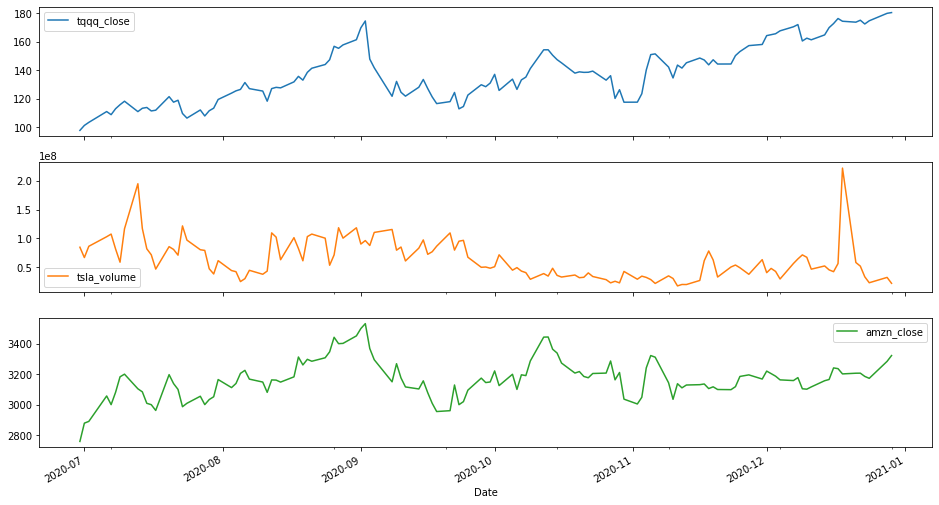

In [20]:
flattened_df[['tqqq_close', 'tsla_volume', 'amzn_close']].plot(subplots=True)

In [21]:
df = flattened_df.apply(lambda row: row.astype(np.float32))
df.dtypes

fb_open        float32
fb_high        float32
fb_low         float32
fb_close       float32
fb_volume      float32
tqqq_open      float32
tqqq_high      float32
tqqq_low       float32
tqqq_close     float32
tqqq_volume    float32
nflx_open      float32
nflx_high      float32
nflx_low       float32
nflx_close     float32
nflx_volume    float32
fcel_open      float32
fcel_high      float32
fcel_low       float32
fcel_close     float32
fcel_volume    float32
jets_open      float32
jets_high      float32
jets_low       float32
jets_close     float32
jets_volume    float32
amzn_open      float32
amzn_high      float32
amzn_low       float32
amzn_close     float32
amzn_volume    float32
aapl_open      float32
aapl_high      float32
aapl_low       float32
aapl_close     float32
aapl_volume    float32
baba_open      float32
baba_high      float32
baba_low       float32
baba_close     float32
baba_volume    float32
tsla_open      float32
tsla_high      float32
tsla_low       float32
tsla_close 

In [22]:
df.head()

,fb_open,fb_high,fb_low,fb_close,fb_volume,tqqq_open,tqqq_high,tqqq_low,tqqq_close,tqqq_volume,...,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,goog_open,goog_high,goog_low,goog_close,goog_volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,220.589996,227.500000,218.470001,227.070007,33927100.0,92.320000,98.480003,92.129997,97.650002,31423600.0,...,201.300003,217.537994,200.746002,215.962006,84592496.0,1390.439941,1418.650024,1383.959961,1413.609985,2042400.0
2020-07-01,228.500000,239.000000,227.559998,237.550003,43399700.0,97.860001,102.470001,97.239998,101.139999,31517200.0,...,216.600006,227.065994,216.100006,223.925995,66634500.0,1411.099976,1443.000000,1409.819946,1438.040039,1775200.0
2020-07-02,239.000000,240.000000,232.610001,233.419998,30633600.0,104.290001,105.870003,102.739998,103.290001,28519000.0,...,244.296005,245.600006,237.119995,241.731995,86250496.0,1446.939941,1482.949951,1446.420044,1464.699951,1859100.0
2020-07-06,233.759995,240.399994,232.270004,240.279999,26206200.0,107.300003,111.580002,107.290001,110.879997,26498000.0,...,255.337997,275.558014,253.207993,274.316010,102849504.0,1480.060059,1506.589966,1472.859985,1495.699951,1564000.0
2020-07-07,239.410004,247.649994,238.820007,240.860001,27887800.0,110.550003,114.160004,108.239998,108.699997,30762400.0,...,281.002014,285.899994,267.342010,277.971985,107448496.0,1490.000000,1516.800049,1483.550049,1485.180054,1458200.0


In [23]:
df.index = df.index.map(pd.Timestamp)

In [27]:
df.index

DatetimeIndex(['2020-06-30', '2020-07-01', '2020-07-02', '2020-07-06',
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
               '2020-07-13', '2020-07-14',
               ...
               '2020-12-15', '2020-12-16', '2020-12-17', '2020-12-18',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-28', '2020-12-29'],
              dtype='datetime64[ns]', name='Date', length=127, freq=None)

In [24]:
df.head()

,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,nflx_open,nflx_high,nflx_low,nflx_close,nflx_volume,...,amzn_open,amzn_high,amzn_low,amzn_close,amzn_volume,jets_open,jets_high,jets_low,jets_close,jets_volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,201.300003,217.537994,200.746002,215.962006,84592496.0,450.019989,457.589996,447.000000,455.040009,4198500.0,...,2685.070068,2769.629883,2675.030029,2758.820068,3769700.0,16.690001,16.825001,16.356001,16.650000,2472500.0
2020-07-01,216.600006,227.065994,216.100006,223.925995,66634500.0,454.000000,488.230011,454.000000,485.640015,9705900.0,...,2757.989990,2895.000000,2754.000000,2878.699951,6363400.0,16.980000,17.350000,16.430000,16.520000,3782500.0
2020-07-02,244.296005,245.600006,237.119995,241.731995,86250496.0,485.640015,492.279999,475.529999,476.890015,6351500.0,...,2912.010010,2955.560059,2871.100098,2890.300049,6593400.0,17.000000,17.094999,16.549999,16.590000,3068500.0
2020-07-06,255.337997,275.558014,253.207993,274.316010,102849504.0,480.769989,499.500000,479.799988,493.809998,7839000.0,...,2934.969971,3059.879883,2930.000000,3057.040039,6880600.0,16.959999,17.100000,16.540001,16.959999,3004600.0
2020-07-07,281.002014,285.899994,267.342010,277.971985,107448496.0,497.309998,504.820007,490.829987,493.160004,5669900.0,...,3058.550049,3069.550049,2990.000000,3000.120117,5257500.0,16.639999,16.650000,16.260000,16.299999,2245000.0


### Feature Engineering

In [23]:
len(df.columns)

50

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [23]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp)).astype(np.float32)
index_timestamp_seconds

array([1.5934897e+09, 1.5935759e+09, 1.5936625e+09, 1.5940081e+09,
       1.5940943e+09, 1.5941809e+09, 1.5942671e+09, 1.5943537e+09,
       1.5946127e+09, 1.5946993e+09, 1.5947855e+09, 1.5948721e+09,
       1.5949583e+09, 1.5952177e+09, 1.5953039e+09, 1.5953905e+09,
       1.5954767e+09, 1.5955633e+09, 1.5958223e+09, 1.5959089e+09,
       1.5959951e+09, 1.5960817e+09, 1.5961679e+09, 1.5964273e+09,
       1.5965135e+09, 1.5966001e+09, 1.5966863e+09, 1.5967729e+09,
       1.5970319e+09, 1.5971185e+09, 1.5972047e+09, 1.5972913e+09,
       1.5973775e+09, 1.5976369e+09, 1.5977231e+09, 1.5978097e+09,
       1.5978959e+09, 1.5979825e+09, 1.5982415e+09, 1.5983281e+09,
       1.5984143e+09, 1.5985009e+09, 1.5985871e+09, 1.5988465e+09,
       1.5989327e+09, 1.5990193e+09, 1.5991055e+09, 1.5991921e+09,
       1.5995377e+09, 1.5996239e+09, 1.5997105e+09, 1.5997967e+09,
       1.6000561e+09, 1.6001423e+09, 1.6002289e+09, 1.6003151e+09,
       1.6004017e+09, 1.6006607e+09, 1.6007473e+09, 1.6008335e

In [24]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

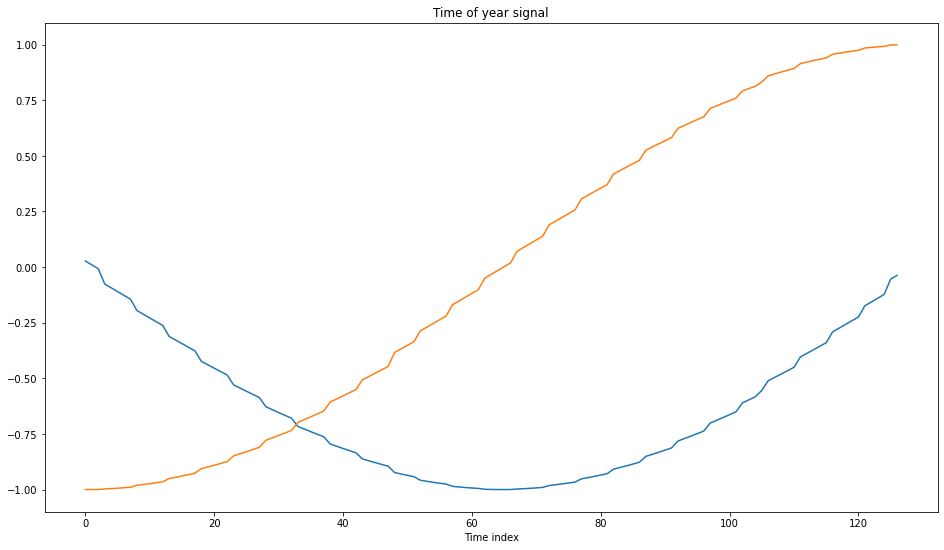

In [25]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

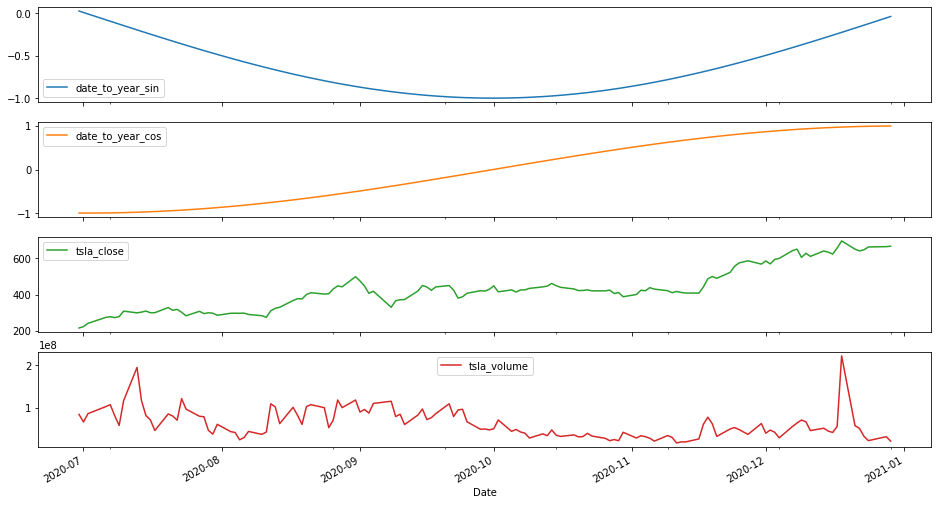

In [26]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df[['date_to_year_sin', 'date_to_year_cos', 'tsla_close', 'tsla_volume']].plot(subplots=True)

In [27]:
df.dtypes

fb_open             float32
fb_high             float32
fb_low              float32
fb_close            float32
fb_volume           float32
tqqq_open           float32
tqqq_high           float32
tqqq_low            float32
tqqq_close          float32
tqqq_volume         float32
nflx_open           float32
nflx_high           float32
nflx_low            float32
nflx_close          float32
nflx_volume         float32
fcel_open           float32
fcel_high           float32
fcel_low            float32
fcel_close          float32
fcel_volume         float32
jets_open           float32
jets_high           float32
jets_low            float32
jets_close          float32
jets_volume         float32
amzn_open           float32
amzn_high           float32
amzn_low            float32
amzn_close          float32
amzn_volume         float32
aapl_open           float32
aapl_high           float32
aapl_low            float32
aapl_close          float32
aapl_volume         float32
baba_open           

### Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [28]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [29]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

We can use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to visualize the probability density of the data at different values. Using a [seaborn violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

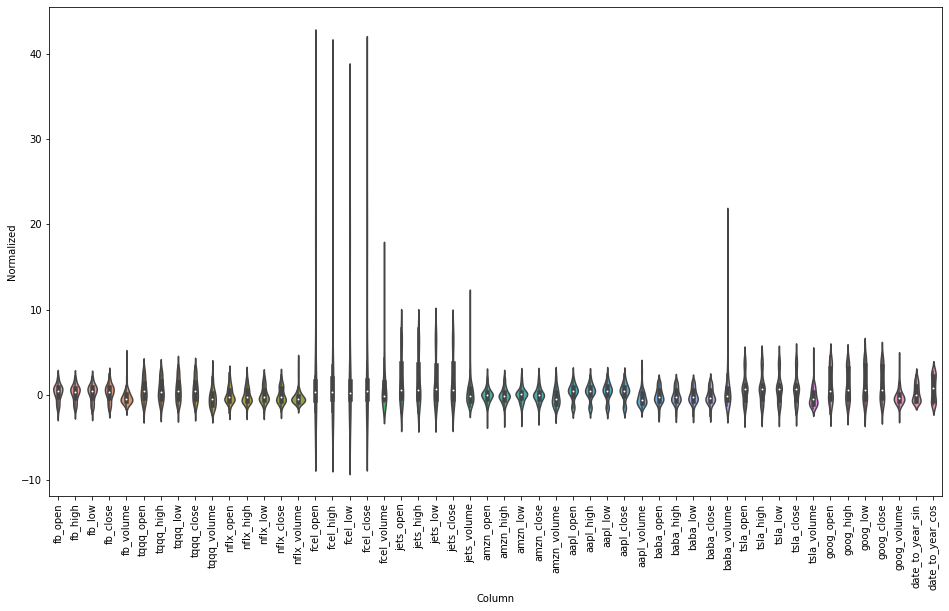

In [30]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

In [38]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='tsla_close', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [timestamp]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

### Single step models



In [39]:
label_columns = ['tsla_close']

In [40]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['tsla_close']

In [41]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 52)
Labels shape (batch, time, features): (32, 1, 1)


#### baseline model

Need something simple to compare more complex models against

In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [43]:
baseline = Baseline(label_index=column_indices[label_columns[0]])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 210ms/step - loss: 0.1060 - mean_absolute_error: 0.2587


In [44]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['tsla_close']

In [45]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 52)
Output shape: (32, 1, 1)


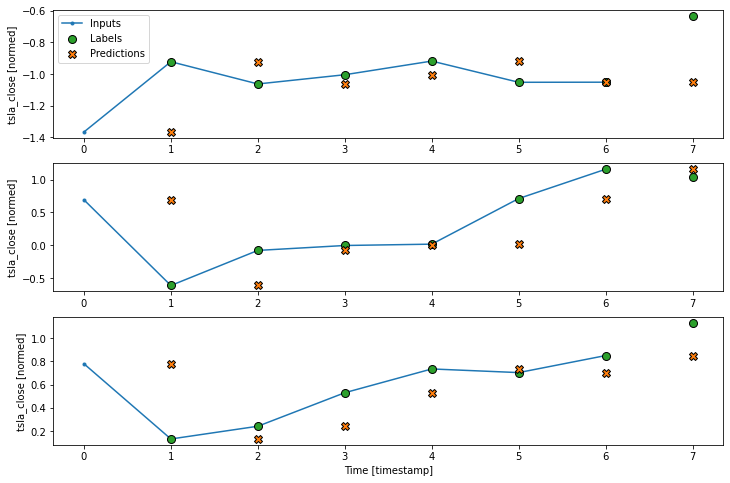

In [46]:
wide_window.plot(baseline)

In [47]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [48]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 52)
Output shape: (32, 1, 1)


In [49]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=0):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.SGD(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [50]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
3/3 [==============================] - 1s 487ms/step - loss: 1.0782 - mean_absolute_error: 0.8421 - val_loss: 82.8164 - val_mean_absolute_error: 7.1365
Epoch 2/50
3/3 [==============================] - 0s 59ms/step - loss: 0.6135 - mean_absolute_error: 0.6347 - val_loss: 57.2028 - val_mean_absolute_error: 5.9702
Epoch 3/50
3/3 [==============================] - 0s 55ms/step - loss: 0.3914 - mean_absolute_error: 0.4917 - val_loss: 42.5866 - val_mean_absolute_error: 5.1983
Epoch 4/50
3/3 [==============================] - 0s 55ms/step - loss: 0.3124 - mean_absolute_error: 0.4570 - val_loss: 34.6100 - val_mean_absolute_error: 4.6988
Epoch 5/50
3/3 [==============================] - 0s 56ms/step - loss: 0.2981 - mean_absolute_error: 0.4556 - val_loss: 30.3493 - val_mean_absolute_error: 4.4019
Epoch 6/50
3/3 [==============================] - 0s 56ms/step - loss: 0.2487 - mean_absolute_error: 0.4097 - val_loss: 27.2184 - val_mean_absolute_error: 4.1751
Epoch 7/50
3/3 [===========

In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 7, 52)
Output shape: (32, 7, 1)


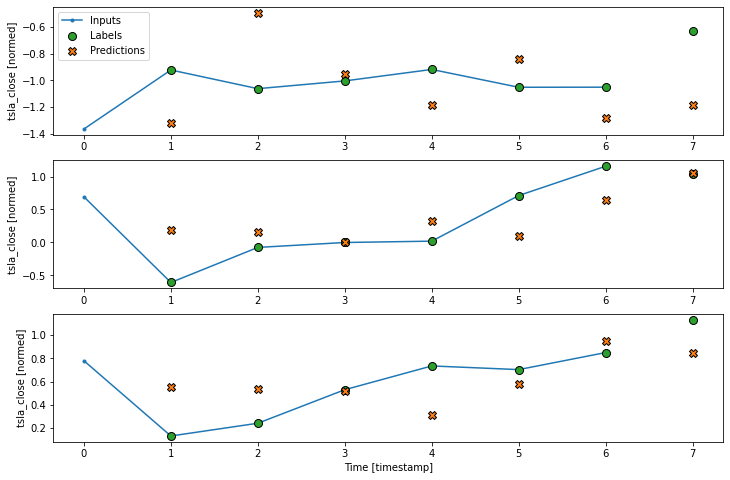

In [52]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input:

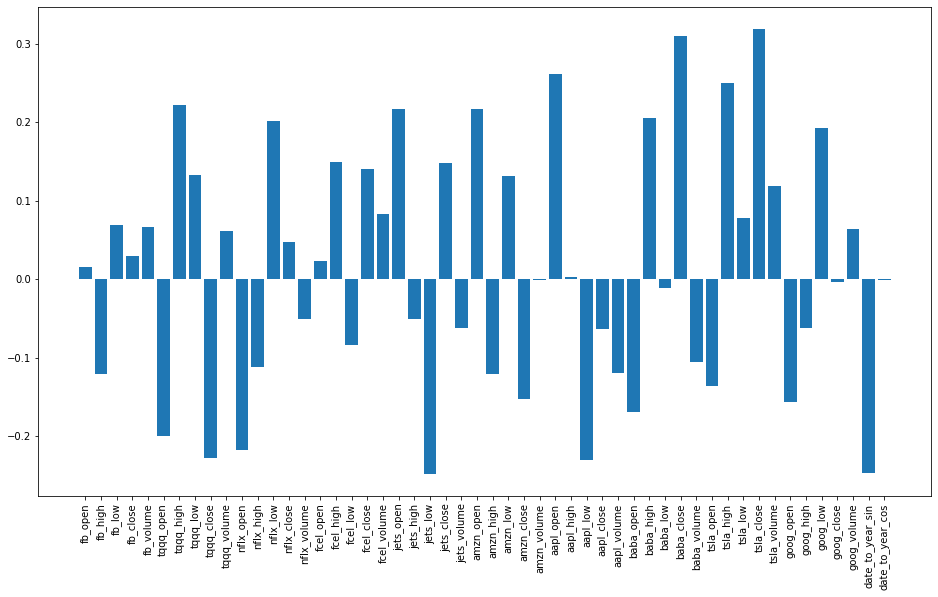

In [53]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `tsla_close`. This is one of the risks of random initialization.

### Dense

In [54]:
%%time
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/50
3/3 [==============================] - 1s 141ms/step - loss: 1.4110 - mean_absolute_error: 0.9639 - val_loss: 20.7782 - val_mean_absolute_error: 3.9146
Epoch 2/50
3/3 [==============================] - 0s 57ms/step - loss: 0.5112 - mean_absolute_error: 0.5643 - val_loss: 16.1807 - val_mean_absolute_error: 3.3267
Epoch 3/50
3/3 [==============================] - 0s 55ms/step - loss: 0.2993 - mean_absolute_error: 0.4028 - val_loss: 14.3838 - val_mean_absolute_error: 3.0860
Epoch 4/50
3/3 [==============================] - 0s 59ms/step - loss: 0.2286 - mean_absolute_error: 0.3512 - val_loss: 14.1002 - val_mean_absolute_error: 3.0471
Epoch 5/50
3/3 [==============================] - 0s 57ms/step - loss: 0.1698 - mean_absolute_error: 0.3141 - val_loss: 14.6113 - val_mean_absolute_error: 3.1037
Epoch 6/50
3/3 [==============================] - 0s 52ms/step - loss: 0.2029 - mean_absolute_error: 0.3364 - val_loss: 13.6431 - val_mean_absolute_error: 2.9931
Epoch 7/50
3/3 [===========

1/1 [==============================] - 0s 64ms/step - loss: 13.8161 - mean_absolute_error: 3.6513
CPU times: user 9.5 s, sys: 716 ms, total: 10.2 s
Wall time: 8.71 s


#### Multi-step dense

In [55]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=label_columns)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['tsla_close']

Text(0.5, 1.0, 'Given 3 days as input, predict 1 day into the future.')

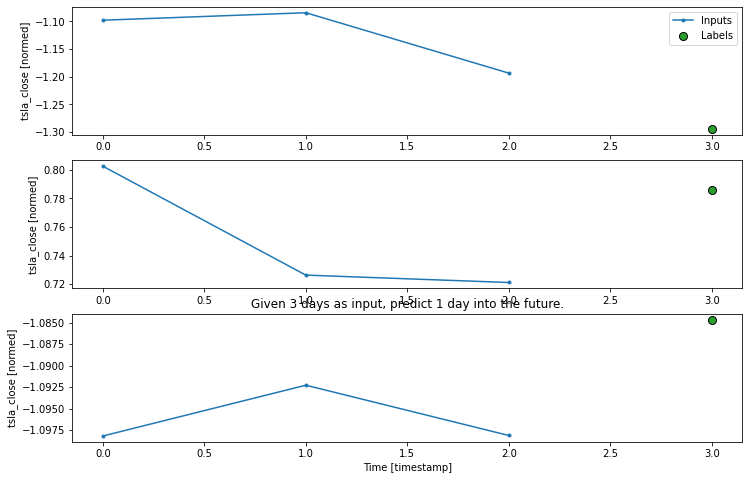

In [56]:
conv_window.plot()
plt.title("Given 3 days as input, predict 1 day into the future.")

You could train a dense model on a multiple-input-step window by adding a layers.Flatten as the first layer of the model

In [57]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [58]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 52)
Output shape: (32, 1, 1)


In [59]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

1/1 [==============================] - 0s 55ms/step - loss: 0.8879 - mean_absolute_error: 0.6900
CPU times: user 3.37 s, sys: 252 ms, total: 3.62 s
Wall time: 3.1 s


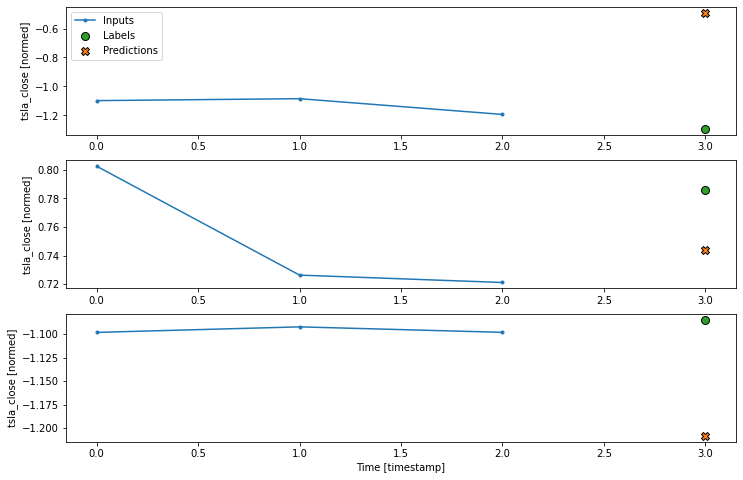

In [60]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape.

In [66]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 7, 52)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 156 but received input with shape (32, 364)


### Convolution neural network

In [67]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [68]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 52)
Output shape: (32, 1, 1)


In [69]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 62ms/step - loss: 0.8093 - mean_absolute_error: 0.7029
CPU times: user 4.41 s, sys: 298 ms, total: 4.71 s
Wall time: 4.17 s


In [70]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 7, 52)
Labels shape: (32, 7, 1)
Output shape: (32, 5, 1)


In [71]:
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=label_columns)

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): ['tsla_close']

In [72]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 9, 52)
Labels shape: (32, 7, 1)
Output shape: (32, 7, 1)


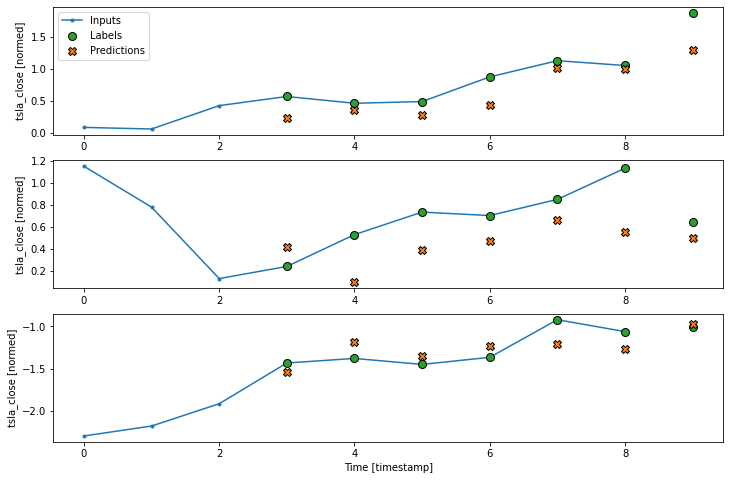

In [73]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

In [74]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [75]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 7, 52)
Output shape: (32, 7, 1)


In [76]:
%%time
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

Epoch 1/50
3/3 [==============================] - 2s 259ms/step - loss: 0.8102 - mean_absolute_error: 0.8248 - val_loss: 6.5873 - val_mean_absolute_error: 2.1352
Epoch 2/50
3/3 [==============================] - 0s 54ms/step - loss: 0.5852 - mean_absolute_error: 0.6870 - val_loss: 6.3958 - val_mean_absolute_error: 2.0615
Epoch 3/50
3/3 [==============================] - 0s 58ms/step - loss: 0.4857 - mean_absolute_error: 0.6086 - val_loss: 6.3257 - val_mean_absolute_error: 2.0272
Epoch 4/50
3/3 [==============================] - 0s 55ms/step - loss: 0.4202 - mean_absolute_error: 0.5505 - val_loss: 6.2855 - val_mean_absolute_error: 2.0056
Epoch 5/50
3/3 [==============================] - 0s 58ms/step - loss: 0.3701 - mean_absolute_error: 0.5024 - val_loss: 6.2532 - val_mean_absolute_error: 1.9906
Epoch 6/50
3/3 [==============================] - 0s 60ms/step - loss: 0.3371 - mean_absolute_error: 0.4753 - val_loss: 6.2488 - val_mean_absolute_error: 1.9850
Epoch 7/50
3/3 [=================

1/1 [==============================] - 0s 65ms/step - loss: 11.3402 - mean_absolute_error: 3.3463
CPU times: user 11.9 s, sys: 1.39 s, total: 13.3 s
Wall time: 10.5 s


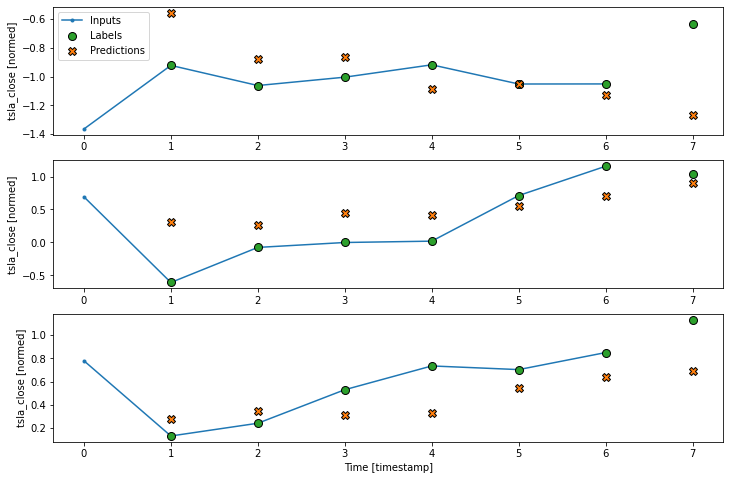

In [77]:
wide_window.plot(lstm_model)

### Performance

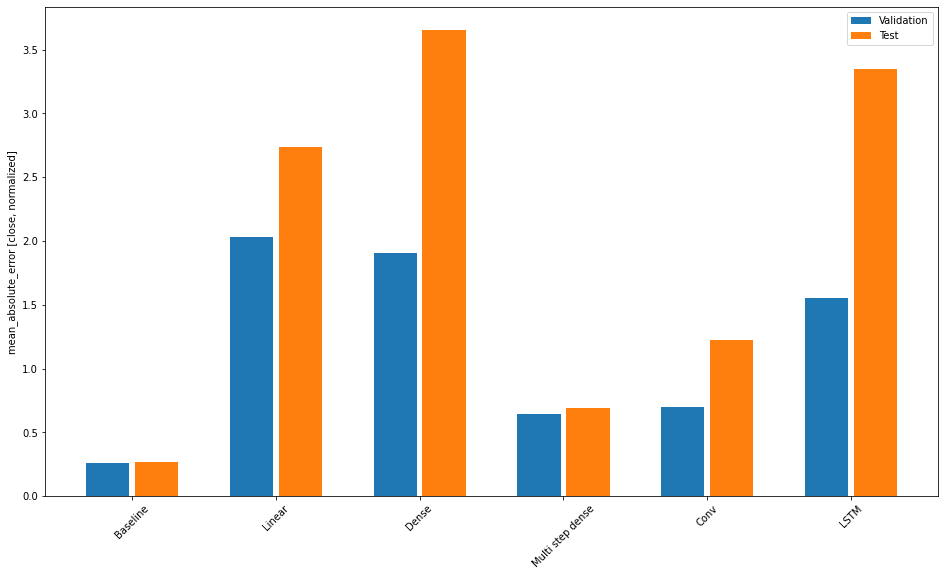

In [78]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [79]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2663
Linear      : 2.7366
Dense       : 3.6513
Multi step dense: 0.6900
Conv        : 1.2259
LSTM        : 3.3463


### Multi Output Models

In [80]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 52)
Labels shape (batch, time, features): (32, 7, 52)


In [81]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [82]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 116ms/step - loss: 1.9928 - mean_absolute_error: 0.5861


In [83]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [84]:
%%time
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

1/1 [==============================] - 0s 53ms/step - loss: 56.1109 - mean_absolute_error: 4.6072
CPU times: user 9.03 s, sys: 746 ms, total: 9.77 s
Wall time: 8.15 s


In [85]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

In [86]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [87]:
%%time
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


1/1 [==============================] - 0s 60ms/step - loss: 20.9088 - mean_absolute_error: 2.3629
CPU times: user 11.6 s, sys: 1.51 s, total: 13.1 s
Wall time: 10.2 s


In [88]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [89]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

1/1 [==============================] - 0s 59ms/step - loss: 1.9928 - mean_absolute_error: 0.5861

CPU times: user 3.2 s, sys: 195 ms, total: 3.39 s
Wall time: 3.09 s


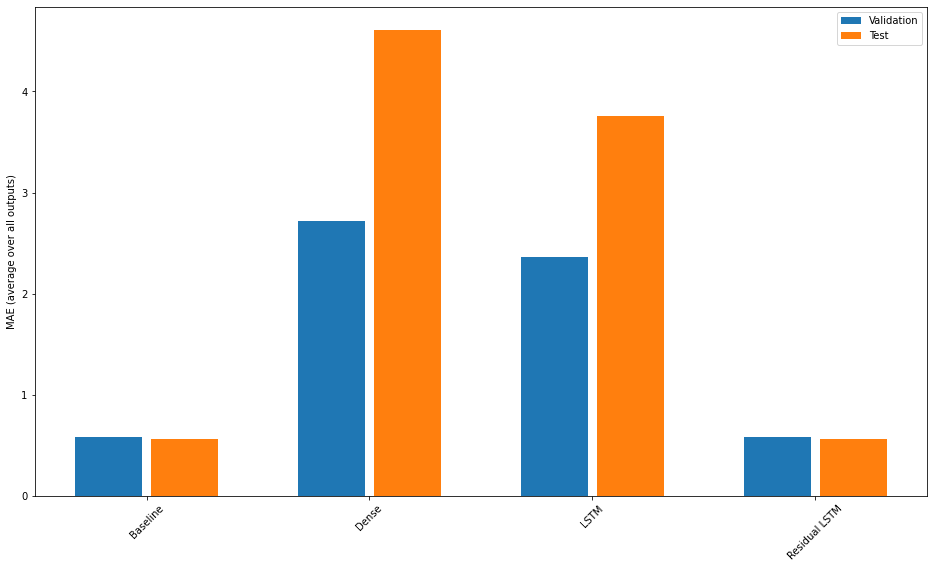

In [90]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Multi Step Models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

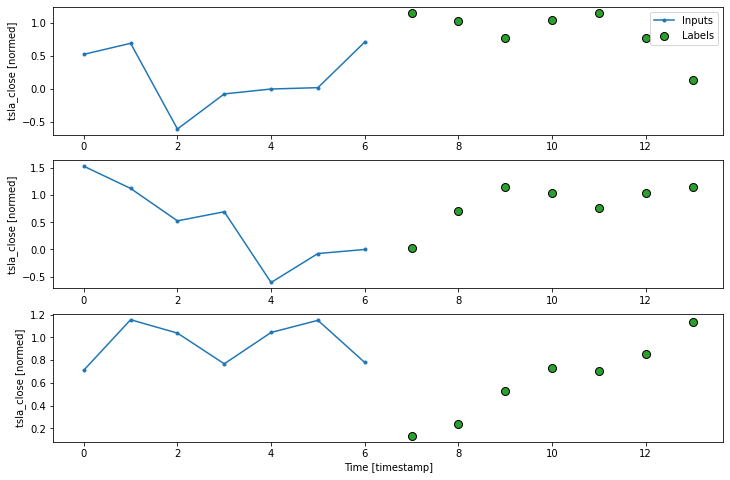

In [91]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

1/1 [==============================] - 0s 143ms/step - loss: 7.8503 - mean_absolute_error: 1.1606


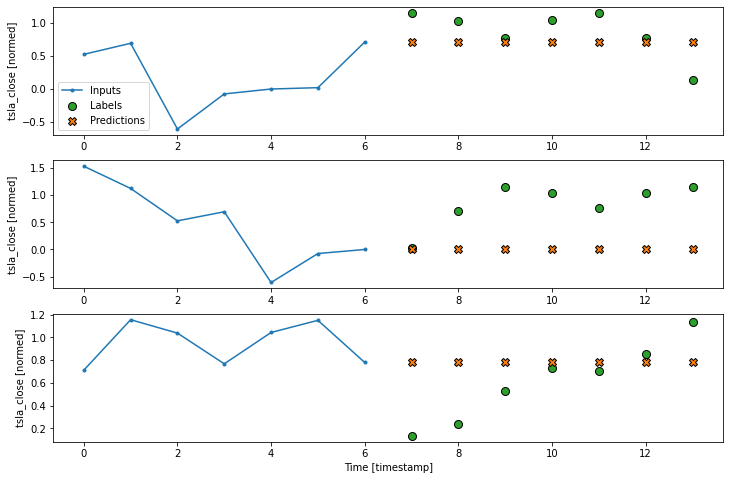

In [92]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

1/1 [==============================] - 0s 122ms/step - loss: 14.8363 - mean_absolute_error: 1.6856


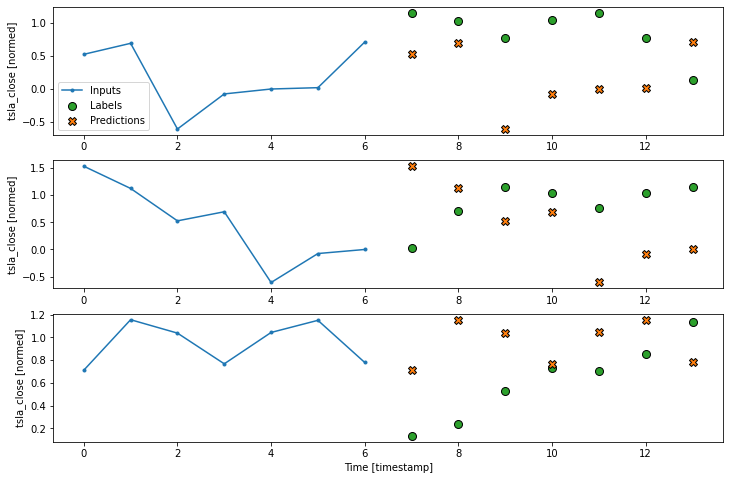

In [93]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

1/1 [==============================] - 0s 57ms/step - loss: 28.3891 - mean_absolute_error: 2.7998
CPU times: user 8.9 s, sys: 627 ms, total: 9.52 s
Wall time: 8.24 s


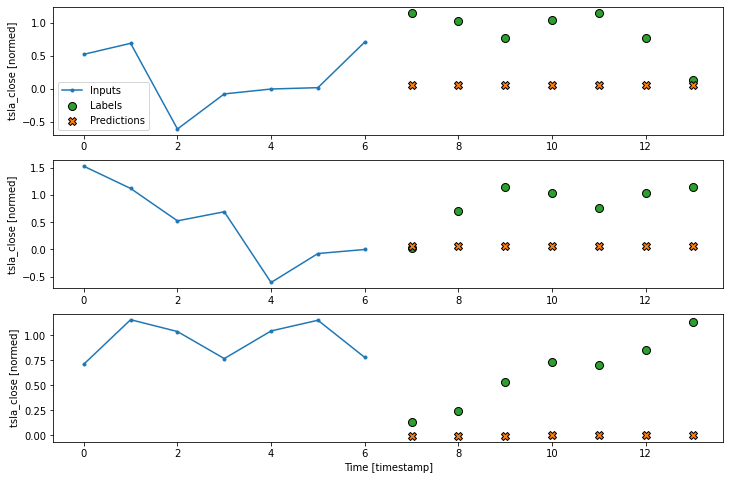

In [94]:
%%time
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

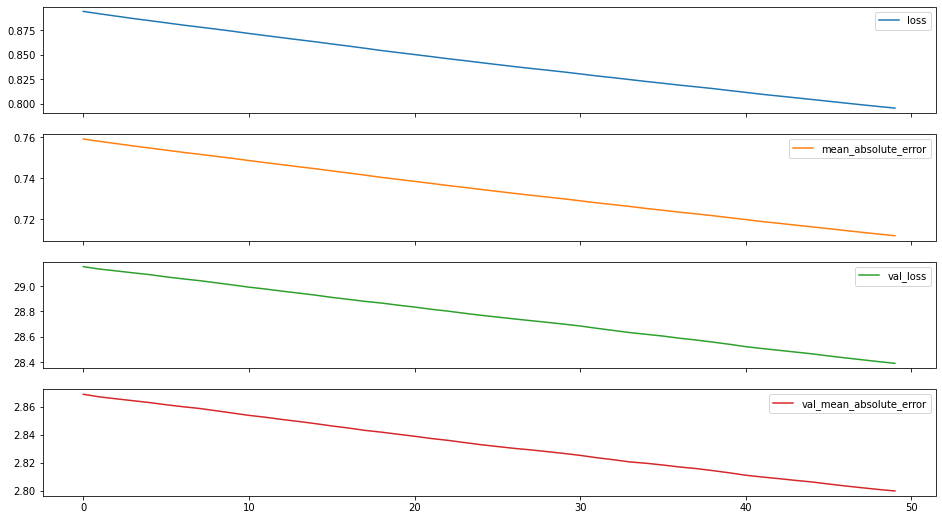

In [95]:
pd.DataFrame(history.history).plot(subplots=True)

### Dense
Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

1/1 [==============================] - 0s 55ms/step - loss: 28.5916 - mean_absolute_error: 2.8074
CPU times: user 9.21 s, sys: 713 ms, total: 9.93 s
Wall time: 8.31 s


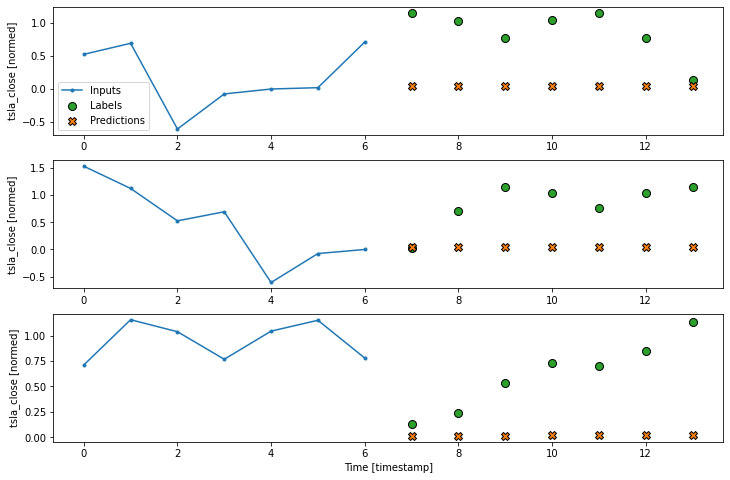

In [96]:
%%time
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

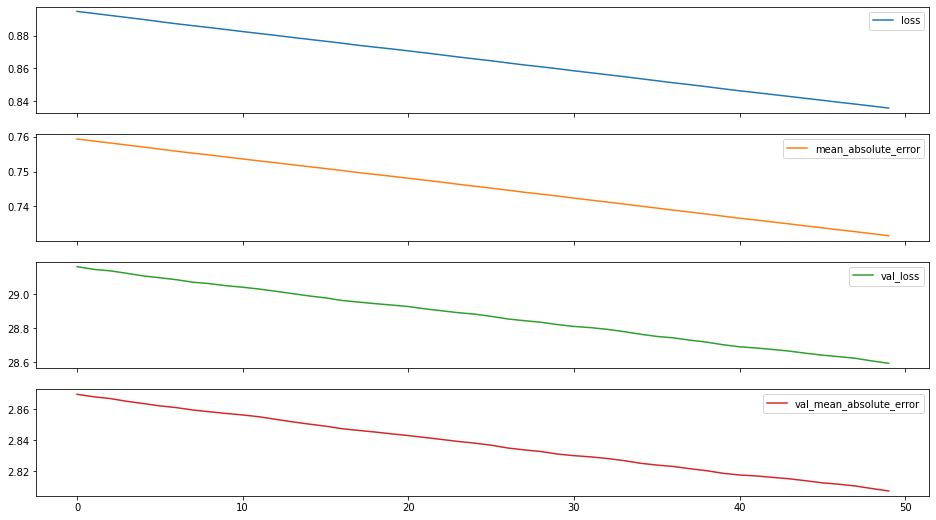

In [97]:
pd.DataFrame(history.history).plot(subplots=True)

### CNN

1/1 [==============================] - 0s 58ms/step - loss: 28.8425 - mean_absolute_error: 2.8271
CPU times: user 9.23 s, sys: 698 ms, total: 9.93 s
Wall time: 8.48 s


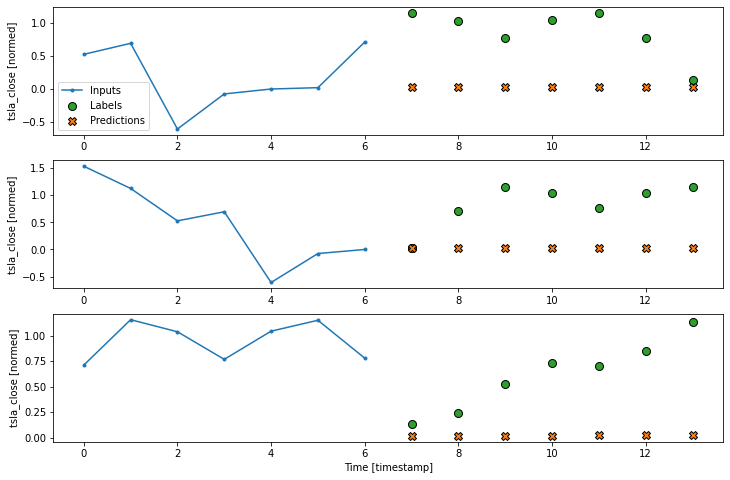

In [98]:
%%time
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

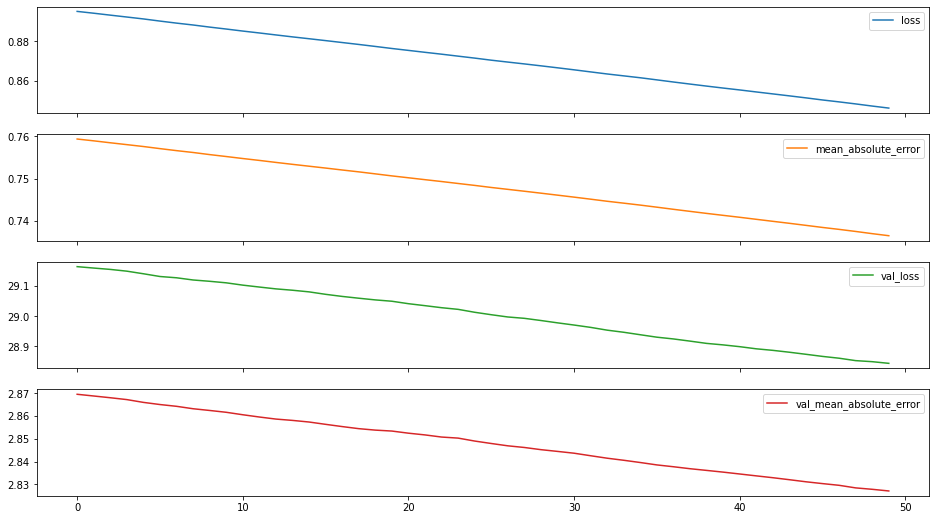

In [99]:
pd.DataFrame(history.history).plot(subplots=True)

### RNN

1/1 [==============================] - 0s 52ms/step - loss: 29.1634 - mean_absolute_error: 2.8697
CPU times: user 11.6 s, sys: 1.57 s, total: 13.2 s
Wall time: 10.3 s


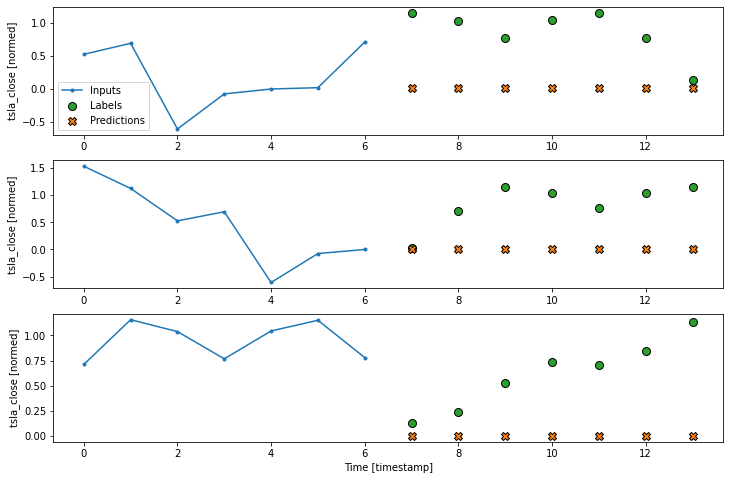

In [100]:
%%time
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

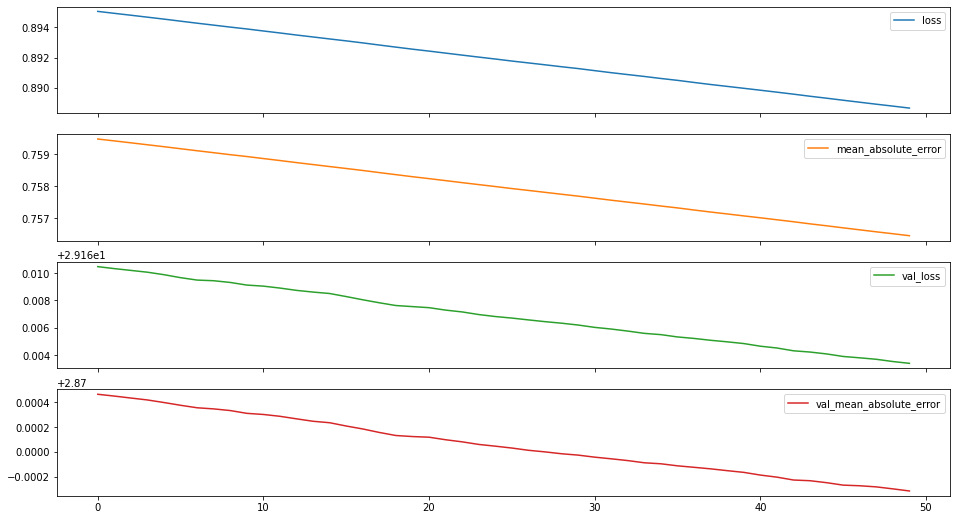

In [101]:
pd.DataFrame(history.history).plot(subplots=True)

### Advanced: Autoregressive model

#### RNN

In [102]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
   
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [103]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [104]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 52])

In [105]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 52)


1/1 [==============================] - 0s 58ms/step - loss: 28.7523 - mean_absolute_error: 2.8480
CPU times: user 12.1 s, sys: 1.7 s, total: 13.8 s
Wall time: 10.5 s


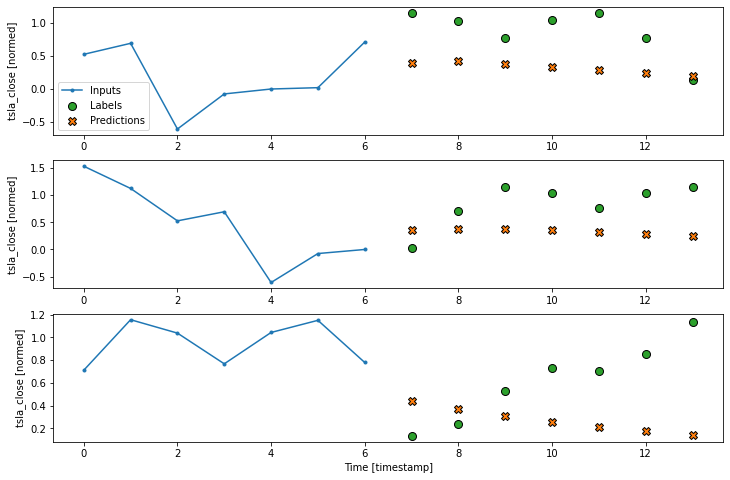

In [106]:
%%time
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

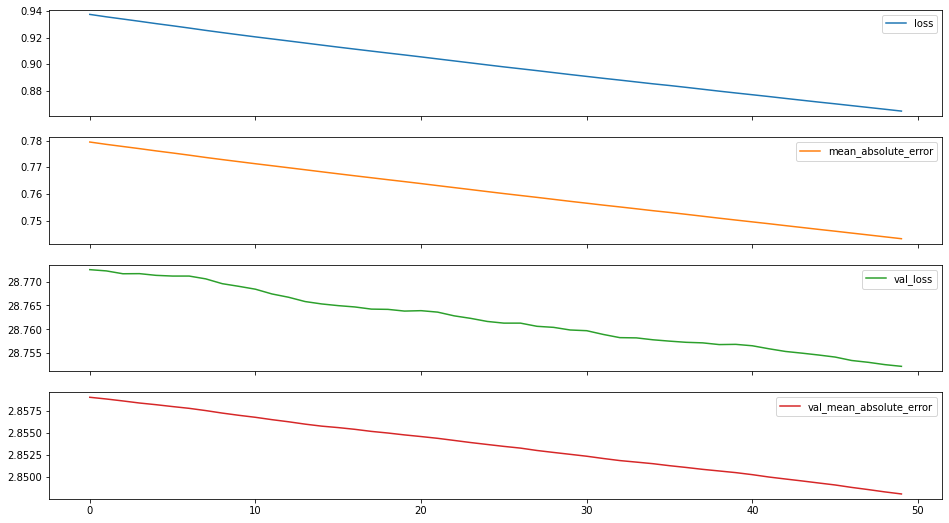

In [107]:
pd.DataFrame(history.history).plot(subplots=True)

### Reference Multi Step LSTM Models

[stacked-lstms-with-dropout](https://www.sciencedirect.com/science/article/pii/S1877050920304865)

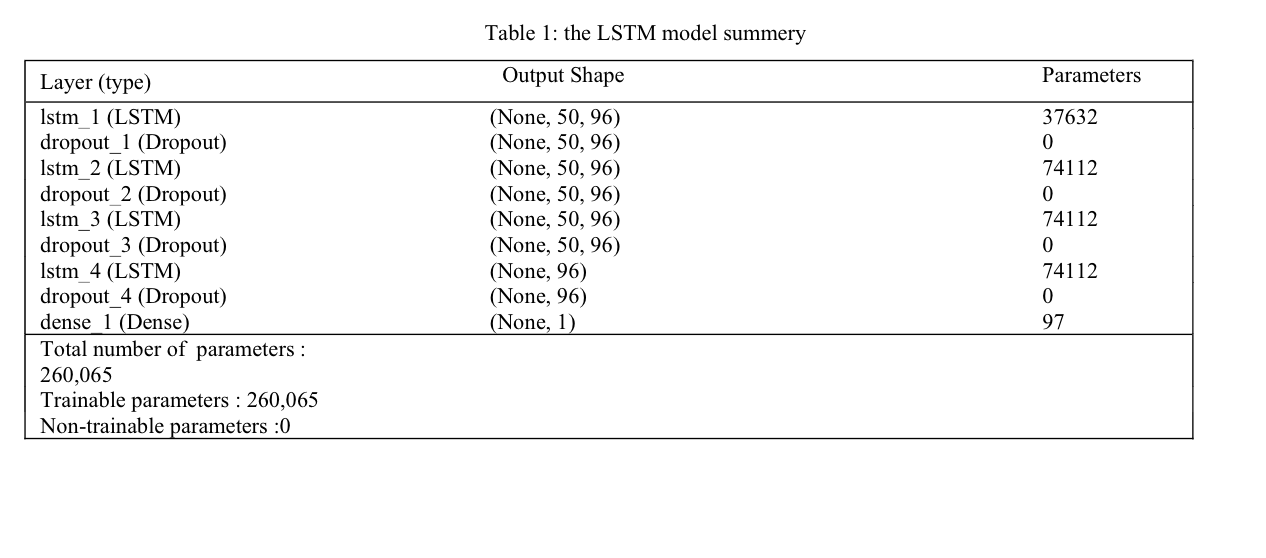

1/1 [==============================] - 0s 58ms/step - loss: 29.1687 - mean_absolute_error: 2.8700
CPU times: user 21.9 s, sys: 3.28 s, total: 25.2 s
Wall time: 17.7 s


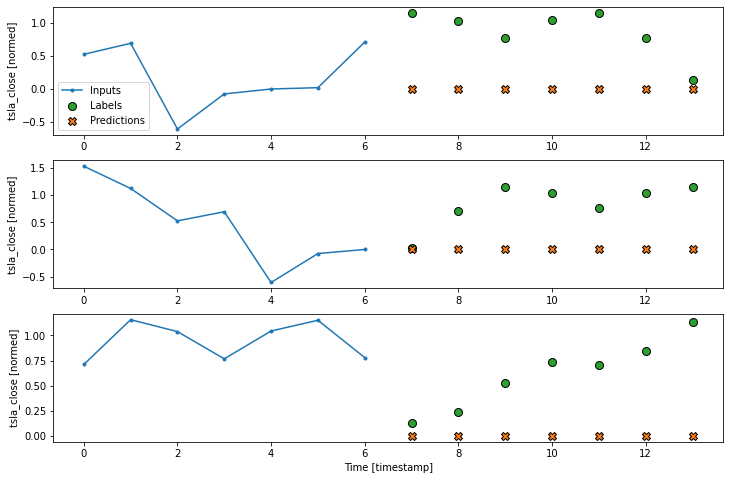

In [108]:
%%time
stacked_lstm_dropout_reference_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(stacked_lstm_dropout_reference_model, multi_window)

IPython.display.clear_output()
multi_val_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.val)
multi_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(stacked_lstm_dropout_reference_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

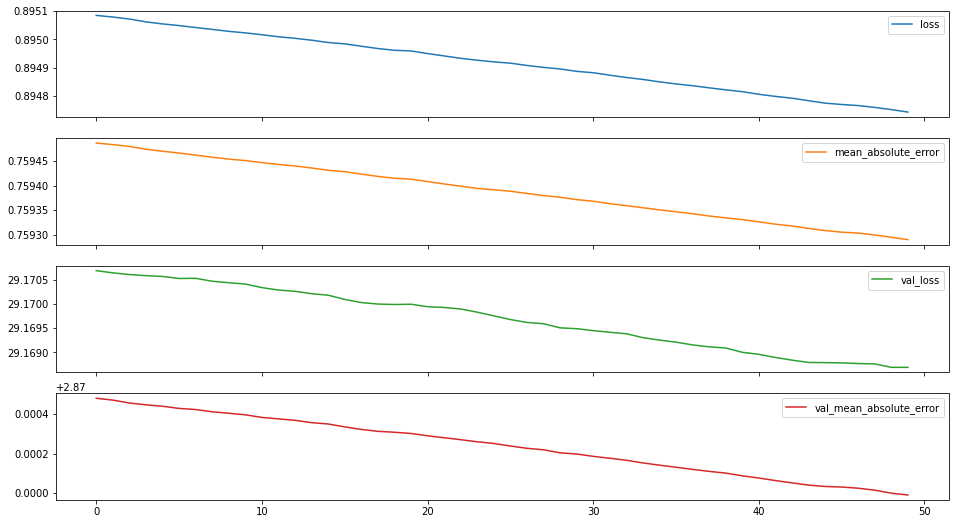

In [109]:
pd.DataFrame(history.history).plot(subplots=True)

### Custom Multi Step Models

Using a CNN with average pooling and dropout layer in front of stacked Bidirectional LSTM layers.

1/1 [==============================] - 0s 50ms/step - loss: 29.1691 - mean_absolute_error: 2.8700
CPU times: user 17.5 s, sys: 1.63 s, total: 19.1 s
Wall time: 15.4 s


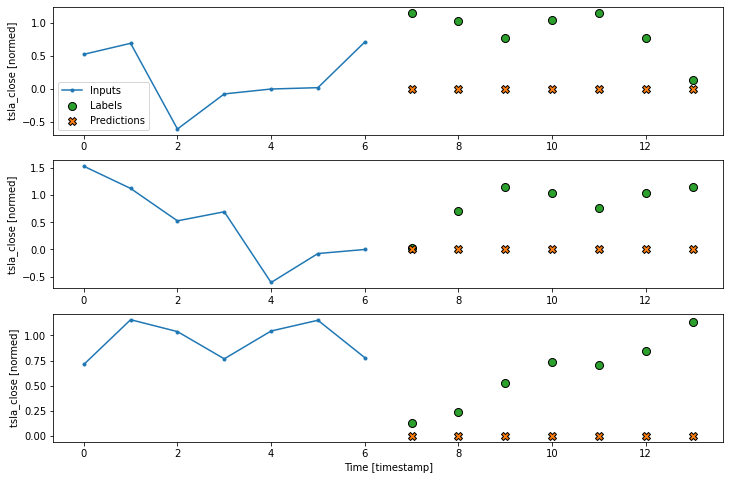

In [110]:
%%time
custom_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.AveragePooling1D(1),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(custom_model, multi_window)

IPython.display.clear_output()
multi_val_performance['custom_model'] = custom_model.evaluate(multi_window.val)
multi_performance['custom_model'] = custom_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(custom_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

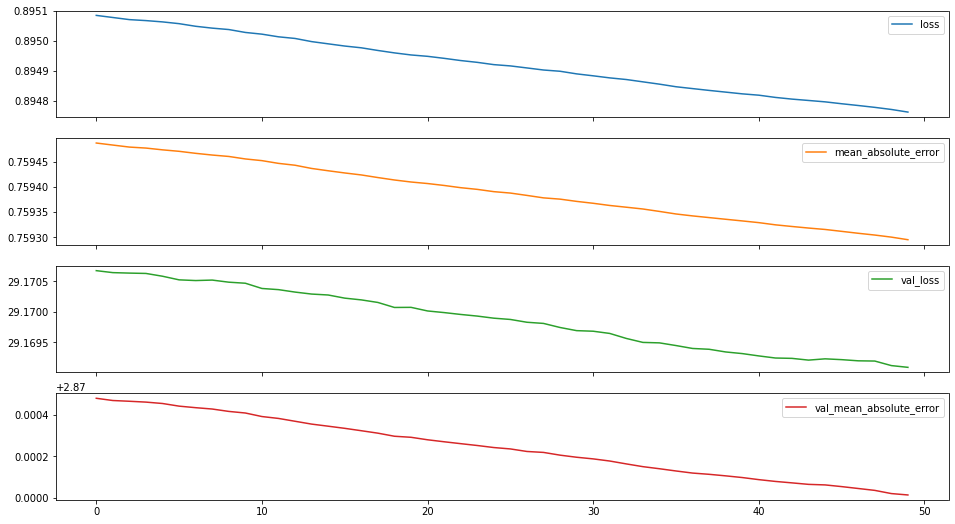

In [111]:
pd.DataFrame(history.history).plot(subplots=True)

### Performance

In [123]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

{'Last': [7.850305557250977, 1.160631775856018], 'Repeat': [], 'Linear': [], 'Dense': [], 'Conv': [], 'LSTM': [], 'AR LSTM': [], 'stacked_lstm_dropout_reference_model': [], 'custom_model': []}


In [122]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 1.1606


IndexError: list index out of range

Peeking at some other predictions made by the custom model... it predicts all features!

In [ ]:
for plot_col in ['aapl_close', 'amzn_open', 'spy_volume', 'wmt_close', 'tsla_volume', 'ge_close', 'tqqq_close', 'vz_volume']:
    multi_window.plot(custom_model, plot_col)

Store the trained model weights

In [ ]:
custom_model.save_weights('./checkpoints/custom-model')

### Making predictions with the saved model